# JPX Tokyo Stock Exchange Prediction Challenge

## Time Series Analysis

Authors: Jeremy Jang (jj2798), Kevin Lee (kl3642), Kevin Zheng (kz1252)

We acquired our data from an active Kaggle competition: JPX Tokyo Stock Exchange Prediction
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction

The question we want to solve is: Are we able to predict the future returns of the stocks traded on the JPX Tokyo Stock Exchange using only stock history data?

We intend to use ARIMA (SARIMAX) for our time-series analysis.

## 1. Preliminary EDA

Necessary Packages

In [41]:
# If you need missingno

!pip install missingno

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#need to import all of the relevant sklearn stuff and corr/arma models
from statsmodels.tsa.statespace.sarimax import SARIMAX

First we load the data into the variable `df`.

In [3]:
df = pd.read_csv('stock_prices.csv', parse_dates=['Date'],index_col='Date')
df.index = pd.DatetimeIndex(df.index).to_period('D')

In [4]:
df.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


We acquired our data from an active Kaggle competition: JPX Tokyo Stock Exchange Prediction
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction

Now let's take a look at each feature and the target...

The question we want to solve is: Are we able to predict the future returns of the stocks traded on the JPX Tokyo Stock Exchange using only stock history data.

In [5]:
print(df.info())

print('\nUnique Securities:')
print(df.SecuritiesCode.unique())
print('Num unique: ',len(df.SecuritiesCode.unique()))
print('AKA 2000 total tickers')

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Freq: D
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   SecuritiesCode    int64  
 2   Open              float64
 3   High              float64
 4   Low               float64
 5   Close             float64
 6   Volume            int64  
 7   AdjustmentFactor  float64
 8   ExpectedDividend  float64
 9   SupervisionFlag   bool   
 10  Target            float64
dtypes: bool(1), float64(7), int64(2), object(1)
memory usage: 198.0+ MB
None

Unique Securities:
[1301 1332 1333 ... 4168 7342 4169]
Num unique:  2000
AKA 2000 total tickers


We can take a look at the summary statistics for the features to get a better understanding of the behaviors of the data, as well as analyze anomalous instances.

In [6]:
print(df.describe())

       SecuritiesCode          Open          High           Low         Close  \
count    2.332531e+06  2.324923e+06  2.324923e+06  2.324923e+06  2.324923e+06   
mean     5.894835e+03  2.594511e+03  2.626540e+03  2.561227e+03  2.594023e+03   
std      2.404161e+03  3.577192e+03  3.619363e+03  3.533494e+03  3.576538e+03   
min      1.301000e+03  1.400000e+01  1.500000e+01  1.300000e+01  1.400000e+01   
25%      3.891000e+03  1.022000e+03  1.035000e+03  1.009000e+03  1.022000e+03   
50%      6.238000e+03  1.812000e+03  1.834000e+03  1.790000e+03  1.811000e+03   
75%      7.965000e+03  3.030000e+03  3.070000e+03  2.995000e+03  3.030000e+03   
max      9.997000e+03  1.099500e+05  1.105000e+05  1.072000e+05  1.095500e+05   

             Volume  AdjustmentFactor  ExpectedDividend        Target  
count  2.332531e+06      2.332531e+06      18865.000000  2.332293e+06  
mean   6.919366e+05      1.000508e+00         22.017730  4.450964e-04  
std    3.911256e+06      6.773040e-02         29.88245

And how many NaN values there are...

In [7]:
print('\nNaN Values:')
print(df.isnull().sum())
print('\nTotal NaN: ',df.isnull().sum().sum())


NaN Values:
RowId                     0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

Total NaN:  2344336


<AxesSubplot:>

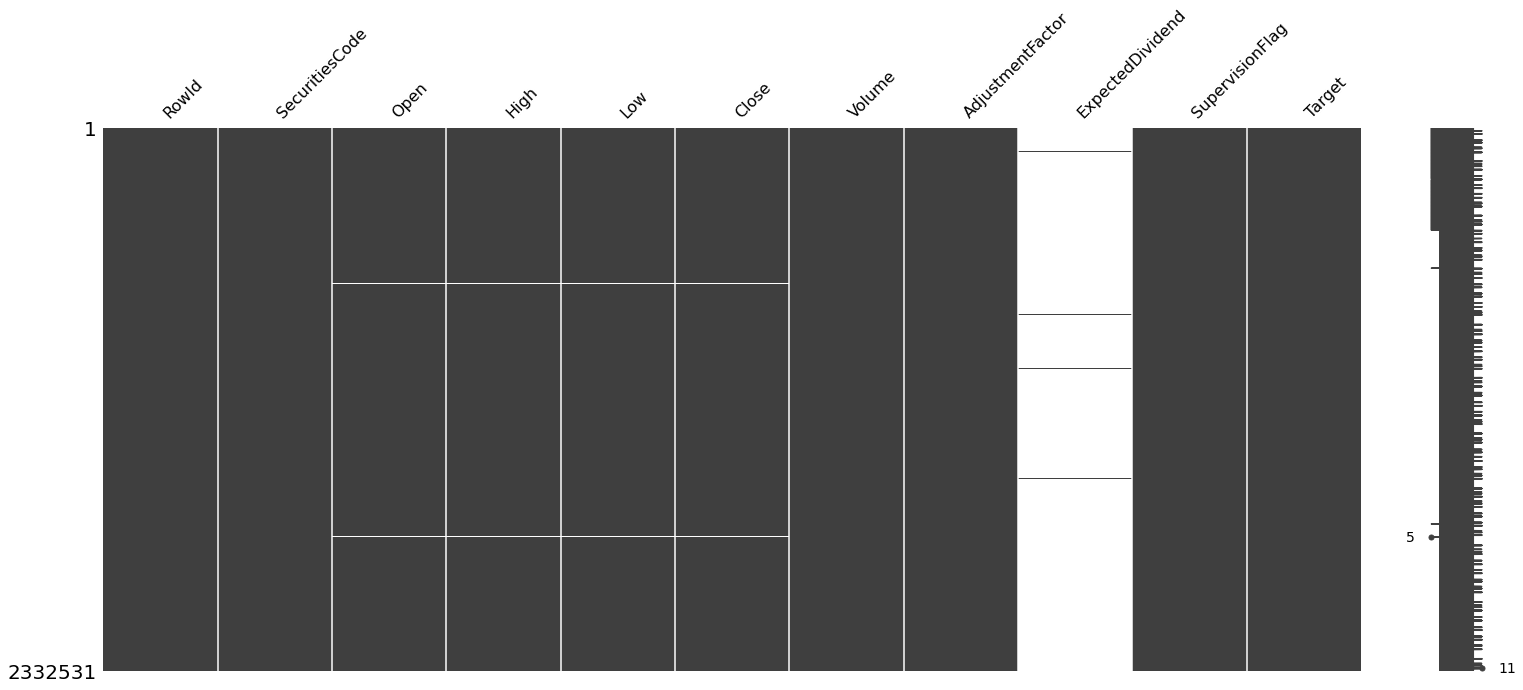

In [8]:
msno.matrix(df)

## 2. Data Exploration and Processing

We can see that there are quite a few missing values, namely from the features `[Open, High, Low, Close, ExpectedDividend, Target]`. The competition provides us with a file that contains the descriptions for each feature in our dataset.

In [9]:
spec = pd.read_csv('stock_price_spec.csv')

In [10]:
spec

,Column,Sample value,Type,Addendum,Remarks
0,RowId,20170104_1301,string,NaN,Unique ID of price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date
2,SecuritiesCode,1301,Int64,NaN,Local securities code
3,Open,2734,float,NaN,first traded price on a day
4,High,2755,float,NaN,highest traded price on a day
5,Low,2730,float,NaN,lowest traded price on a day
6,Close,2742,float,NaN,last traded price on a day
7,Volume,31400,Int64,NaN,number of traded stocks on a day
8,AdjustmentFactor,1,float,NaN,to calculate theoretical price/volume when spl...
9,SupervisionFlag,FALSE,boolean,NaN,Flag of Securities Under Supervision & Securit...


From this information, we can understand that we will not be needing the following features: `[RowId, SupervisionFlag, ExpectedDividend, Target]`. We will need the SecurityCode to pick the stocks to analyze. Our analysis will be chiefly concerned with the date and the close adjusted price of the stocks, so we can disregard `[Open, High, Low]` as well. We have also already determined that the Volume is weakly correlated at best with the close price, so we will also be discarding that feature. The adjustment factor is required to compute the close adjusted price.

In [11]:
# Drop unnecessary columns
df.drop(columns=['RowId','Open','High','Low','Volume','SupervisionFlag','ExpectedDividend','Target'],inplace=True)
df

,SecuritiesCode,Close,AdjustmentFactor
Date,,,
2017-01-04,1301,2742.0,1.0
2017-01-04,1332,571.0,1.0
2017-01-04,1333,3210.0,1.0
2017-01-04,1376,1550.0,1.0
2017-01-04,1377,3330.0,1.0
...,...,...,...
2021-12-03,9990,528.0,1.0
2021-12-03,9991,794.0,1.0
2021-12-03,9993,1645.0,1.0


In [12]:
# Compute Close Adjusted Price
df['close_adj'] = df['Close'] / df['AdjustmentFactor']
df

,SecuritiesCode,Close,AdjustmentFactor,close_adj
Date,,,,
2017-01-04,1301,2742.0,1.0,2742.0
2017-01-04,1332,571.0,1.0,571.0
2017-01-04,1333,3210.0,1.0,3210.0
2017-01-04,1376,1550.0,1.0,1550.0
2017-01-04,1377,3330.0,1.0,3330.0
...,...,...,...,...
2021-12-03,9990,528.0,1.0,528.0
2021-12-03,9991,794.0,1.0,794.0
2021-12-03,9993,1645.0,1.0,1645.0


In [13]:
df.drop(columns=['Close','AdjustmentFactor'],inplace=True)
df

,SecuritiesCode,close_adj
Date,,
2017-01-04,1301,2742.0
2017-01-04,1332,571.0
2017-01-04,1333,3210.0
2017-01-04,1376,1550.0
2017-01-04,1377,3330.0
...,...,...
2021-12-03,9990,528.0
2021-12-03,9991,794.0
2021-12-03,9993,1645.0


Before we select the stocks to use, we cannot forget about the missing values. There are still 7608 missing entries for `[Open, High, Low, Close]`. Looking back at the matrix of missing values, we can observe that the missing values all occur on the same two instances. Based on this information and some research we did on the stock exchange, we discovered that there were two instances of service outages at the exchange. While normally, it would be inappropriate to include NaN values or impute the missing values in the context of our problem, SARIMAX handles the NaN values for us (disregards them). We will also need to reindex our dataframes anyway, which will introduce more NaN values.

That being said, the ADFuller test requires that there be no NaN values in the input. So we will drop them here and then reindex at a later time.

In [14]:
df.dropna(inplace=True)
df.isnull().sum()

SecuritiesCode    0
close_adj         0
dtype: int64

Now we need to select the stocks to use in our analysis. We decided to choose stocks that reflect different behaviors (bull, bear, neutral). A "bullish" stock is one that experiences a prolonged period of rising stock prices (typically 20% or more over at least 2 months). A "bearish" stock is one that performs the opposite. A "neutral" or "sideways" stock is one whos prices appear to settle at a mean over a prolonged period of time.

Based on these criteria, we decided to use the securities: `[7309,7287,7282]`.

In [15]:
sample_stocks = [7309, 7287, 7282]

Now that we have chosen the stocks to predict on, we can start on some preliminary data analysis. To start, we will plot the close adjusted price over time for each of the stocks chosen to observe any obvious patterns.

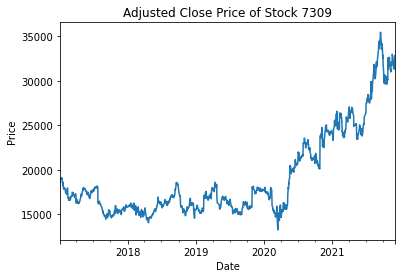

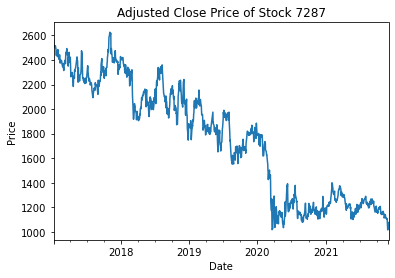

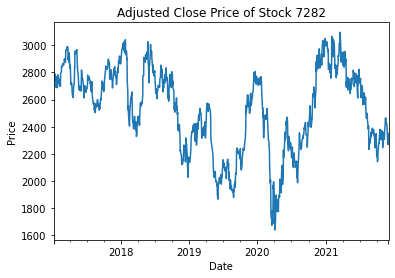

In [16]:
for sample_stock in sample_stocks:
    df[df["SecuritiesCode"] == sample_stock]["close_adj"].plot()
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.title("Adjusted Close Price of Stock {}".format(sample_stock))
    plt.show()

The stocks chosen appear to respectively reflect the different trends defined above. However, to use the SARIMAX model, the data must be stationary. To test stationarity, we will use the adfuller test to calculate the p-value of each stock against a threshold of p=0.05

In [17]:
from statsmodels.tsa.stattools import adfuller
for sample_stock in sample_stocks:
      result = adfuller(df[(df["SecuritiesCode"] == sample_stock)]["close_adj"])
      print("p-value for stock {}: {}\n".format(sample_stock,result[1])) 

        


p-value for stock 7309: 0.9753507669820672

p-value for stock 7287: 0.5279018137455539

p-value for stock 7282: 0.08785546983486303



The null hypothesis for the Augmented Dickey-Fuller test is that the data is non-stationary. Since the p-values for each stock chosen is above the threshold of 0.05, we are unable to reject the null hypothesis. This indicates that we need to modify the data to make it stationary. In this case, we take the first difference of the data and run the adfuller test again. 

ADF statistic of first diff of stock 7309 -35.20846444911144
p-value for first diff of stock 7309 0.0


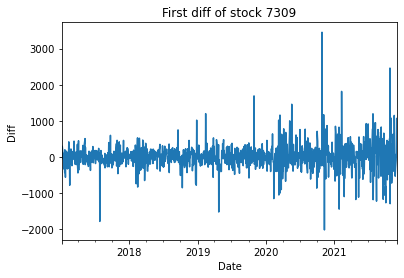

ADF statistic of first diff of stock 7287 -35.73564949218958
p-value for first diff of stock 7287 0.0


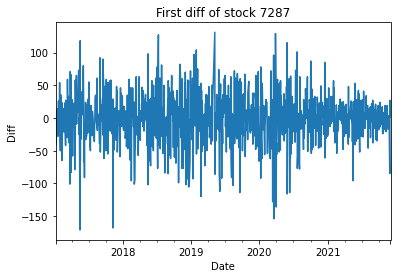

ADF statistic of first diff of stock 7282 -34.43174345364978
p-value for first diff of stock 7282 0.0


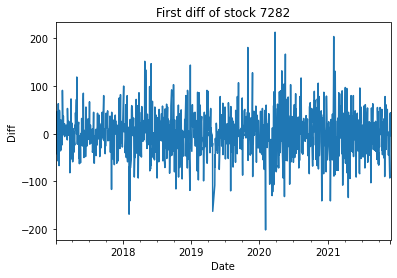

In [18]:
#First Diff
for sample_stock in sample_stocks:

    df_sample = df[(df["SecuritiesCode"] == sample_stock)]["close_adj"].diff().dropna()
    result = adfuller(df_sample)
    print("ADF statistic of first diff of stock {}".format(sample_stock), result[0])
    print("p-value for first diff of stock {}".format(sample_stock), result[1])
    df_sample.plot()
    plt.title("First diff of stock {}".format(sample_stock))
    plt.ylabel("Diff")
    plt.xlabel("Date")
    plt.show()

Running the adfuller test against the first difference, we get a p-value of 0.0 for each stock with a test statistic ~-35.
The low p-value indicates that we are able to reject the null hypothesis that the data is non-stationary, meaning we can use
the first difference to make our data stationary. This will be done by changing the d parameter for our Sarimax model to be 1. 

## 3. Data Modeling

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Before we attempt parameter optimization, we can take a look at the ACF and PACF plots for the differenced data to get an understanding of what model orders might be appropriate.

In [20]:
df_7309_plots = df[(df["SecuritiesCode"] == 7309)]["close_adj"].diff().dropna()
df_7287_plots = df[(df["SecuritiesCode"] == 7287)]["close_adj"].diff().dropna()
df_7282_plots = df[(df["SecuritiesCode"] == 7282)]["close_adj"].diff().dropna()

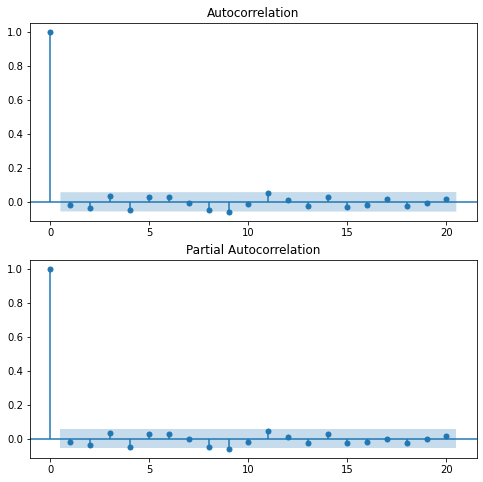

In [21]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))

plot_acf(df_7309_plots,lags=20,ax=ax1)

plot_pacf(df_7309_plots,lags=20,ax=ax2,method='ywm')

plt.show()

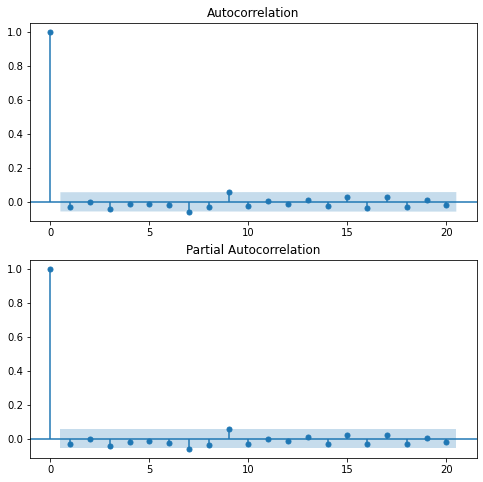

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))

plot_acf(df_7287_plots,lags=20,ax=ax1)

plot_pacf(df_7287_plots,lags=20,ax=ax2,method='ywm')

plt.show()

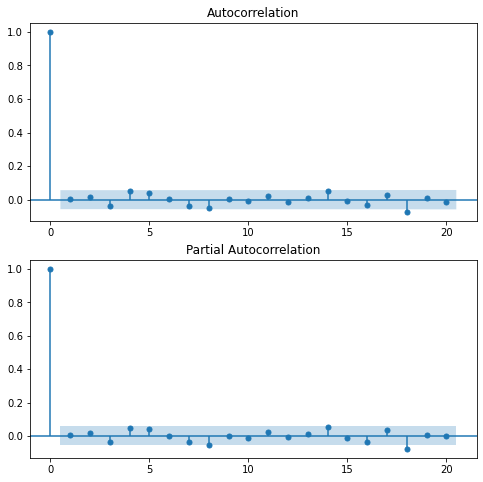

In [23]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))

plot_acf(df_7282_plots,lags=20,ax=ax1)

plot_pacf(df_7282_plots,lags=20,ax=ax2,method='ywm')

plt.show()

From these plots, we can observe that for all three stocks, the suggested model order seems to be (p,q) = (0,0). This suggests that our differenced time-series is a white noise process. This implies that we will not be able to make any meaningful predictions from our models, but we will procede with our analysis anyway.

As we will be using our models to forecast 7, 30, and 183 days ahead. We need to separate our current data into two separate datasets.
Since the data has missing data in between days due to weekends and days in which stock data was not recorded, we will reindex the data so that it includes all days. We will then split the last 183 days off to be used to validate our model, while the rest of the data is used to train our model.

In [24]:
def reindex_and_separate(df, start):
    #create an index from the start date to the end date
    new_index = pd.period_range(df.index[0], df.index[-1], freq=df.index.freq)
    #reindex our dataframe
    df = df.reindex(new_index)
    #split our dataframe into start:183 days from last, and last 183 days
    df_r = df.iloc[:-1*start+1]
    df_t = df.tail(start)
    return df_r, df_t

We will re-establish our data without the differencing, as the SARIMAX object has integration built-in.

In [25]:
df_7309 = df[(df["SecuritiesCode"] == 7309)]["close_adj"].dropna()
df_7287 = df[(df["SecuritiesCode"] == 7287)]["close_adj"].dropna()
df_7282 = df[(df["SecuritiesCode"] == 7282)]["close_adj"].dropna()

We will now reindex and separate all our stock data to extract the last half year, missing values will have NaN

In [26]:
df_7309, df_7309_f = reindex_and_separate(df_7309, 183)
df_7287, df_7287_f = reindex_and_separate(df_7287, 183)
df_7282, df_7282_f = reindex_and_separate(df_7282, 183)


Before we run SARIMAX, we'll create a function to perform the gridsearch using various p, q values to find the optimal (p,0,q) for our SARIMAX model. 

* p -- AR (Auto Regressive) order
* q -- MA (Moving Average) order

In [27]:
def simulate_sarimax(n_p, n_q, df):
    #as the dataframe was reindexed earlier, we will drop na values for the purposes of training the model
    df_n = df.dropna()
    #return dictionary
    aic_bic = []
    #simulating 0...n_p for p, 0...n_q for q
    for p in range(n_p):
        for q in range(n_q):
            try:
                model = SARIMAX(df_n, order = (p,1,q), trend='c')
                results = model.fit(method="powell", disp = False)
                aic_bic.append((p,q,results.aic,results.bic))
            except:
                aic_bic.append((p, q,None,None))

    return_df = pd.DataFrame(aic_bic, columns=['p','q','AIC','BIC'])
    
    return return_df

In [28]:
#get the best (p,q) based on AIC and BIC -- based on smallest AIC/BIC values
def grid_search(df):
    print("Sorted by: AIC")
    print(df.sort_values("AIC"))
    print("\nSorted by: BIC")
    print(df.sort_values("BIC"))
    
    #return best_aic, best_bic

Simulate Sarimax for company code 7309

In [29]:
res_7309 = simulate_sarimax(11,11,df_7309)

C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Use the dataframe produced from varying p & q to find the hyper parameters that produced the lowest AIC and BIC

In [30]:
grid_search(res_7309)

Sorted by: AIC
      p   q           AIC           BIC
9     0   9  15501.531297  15556.332579
99    9   0  15502.382783  15557.184064
10    0  10  15503.475494  15563.258710
19    1   8  15503.816032  15558.617314
20    1   9  15503.865508  15563.648725
..   ..  ..           ...           ...
119  10   9  15522.166974  15626.787603
58    5   3  15523.260318  15573.079664
69    6   3  15523.685757  15578.487038
79    7   2  15523.835296  15578.636577
80    7   3  15525.438482  15585.221698

[121 rows x 4 columns]

Sorted by: BIC
      p   q           AIC           BIC
0     0   0  15512.344168  15522.308037
1     0   1  15514.240221  15529.186025
11    1   0  15514.249751  15529.195555
2     0   2  15513.691907  15533.619646
22    2   0  15513.946762  15533.874501
..   ..  ..           ...           ...
98    8  10  15517.572865  15617.211558
118  10   8  15520.166871  15619.805565
109   9  10  15518.615151  15623.235779
119  10   9  15522.166974  15626.787603
120  10  10  15520.829944

We can see that for company code 7309, the (p,q) pair that produced the lowest AIC was (0,9) and (0,0) for BIC

Simulate SARIMAX for company code 7287

In [31]:
res_7287 = simulate_sarimax(11,11,df_7287)

C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Perform grid search to find optimal p & q 

In [32]:
grid_search(res_7287)

Sorted by: AIC
      p   q           AIC           BIC
0     0   0  10912.851631  10922.815501
24    2   2  10913.355865  10943.247473
11    1   0  10913.756284  10928.702088
1     0   1  10913.757877  10928.703681
19    1   8  10915.624093  10970.425375
..   ..  ..           ...           ...
98    8  10  10933.634039  11033.272733
118  10   8  10933.784406  11033.423099
96    8   8  10934.302799  11023.977623
109   9  10  10935.697991  11040.318619
120  10  10  10937.759720  11047.362283

[121 rows x 4 columns]

Sorted by: BIC
      p   q           AIC           BIC
0     0   0  10912.851631  10922.815501
11    1   0  10913.756284  10928.702088
1     0   1  10913.757877  10928.703681
12    1   1  10915.696071  10935.623809
22    2   0  10915.753816  10935.681555
..   ..  ..           ...           ...
119  10   9  10925.978569  11030.599197
98    8  10  10933.634039  11033.272733
118  10   8  10933.784406  11033.423099
109   9  10  10935.697991  11040.318619
120  10  10  10937.759720

The (p,q) pair that resulted in the lowest AIC/BIC for company code 7287 was (0,0)

Perform SARIMAX on company code 7282

In [33]:
res_7282 = simulate_sarimax(11,11,df_7282)

C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [34]:
grid_search(res_7282)

Sorted by: AIC
      p   q           AIC           BIC
0     0   0  11311.886877  11321.850746
11    1   0  11313.863422  11328.809226
1     0   1  11313.864365  11328.810169
26    2   4  11314.907655  11354.763132
22    2   0  11315.395900  11335.323639
..   ..  ..           ...           ...
76    6  10  11332.356837  11422.031661
120  10  10  11333.375271  11442.977834
117  10   7  11333.713644  11428.370403
107   9   8  11333.784388  11428.441147
118  10   8  11335.708645  11435.347339

[121 rows x 4 columns]

Sorted by: BIC
      p   q           AIC           BIC
0     0   0  11311.886877  11321.850746
11    1   0  11313.863422  11328.809226
1     0   1  11313.864365  11328.810169
22    2   0  11315.395900  11335.323639
2     0   2  11315.429632  11335.357370
..   ..  ..           ...           ...
98    8  10  11331.983038  11431.621732
118  10   8  11335.708645  11435.347339
119  10   9  11331.952683  11436.573311
109   9  10  11332.154001  11436.774629
120  10  10  11333.375271

The (p,q) pair that produced the lowest AIC and BIC was (0,0)

Now that we have the optimal (p,q) order we can build our model. We will create a function to automatically build the model for us with the correct (p,q) order

In [35]:
def create_model(df, p, q):
    #set random seed 
    np.random.seed(1)
    #build SARIMAX model
    model = SARIMAX(df, order = (p,1,q), trend = "ct")
    #fit it to our data
    results = model.fit(disp = False)
    return results

Now we can create the models for each of our stocks

In [36]:
results_7309 = create_model(df_7309, 0, 9)
results_7287 = create_model(df_7287, 0, 0)
results_7282 = create_model(df_7282, 0, 0)

C:\Users\kzhen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 4. Validation and Presentation

Now that we have our models, we can plot our forecast for each stock and compare it to the true price. To accomplish this, we created a function called plot_data()

In [37]:
def plot_data(df, df_t, results, steps, stock_name):
    
    """
    df - the original dataset used to train the model
    df_t - the future dataset used to validate forecast
    results - the model results we got from SARIMAX
    steps - # of steps we want to forecast
    stock_name - security code of the stock
    """
    
    #forward fill the data to fill in gaps
    df = df.ffill()
    df_t = df_t.ffill()
    
    #get our forecast with # of steps
    forecast = results.get_forecast(steps = steps)
    mean = forecast.predicted_mean
    
    #get our confidence interval and index for forecasting
    conf_int = forecast.conf_int()
    dates = mean.index
    
    #to make our plot fit, we will only be examining the last 100 days of our original data
    df.tail(100).plot(label = "Past")
    plt.plot(dates,mean, label = "Forecast")
    df_t.head(steps).plot(label = "True")
    plt.plot()
    
    #plot our confidence interval
    plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha = 0.5)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.title("Forecasted Adjusted Close Price vs. True: {}, {} days".format(stock_name, steps))
    plt.show()
    

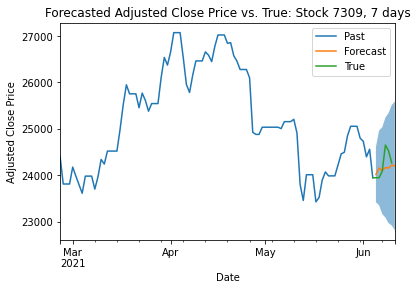

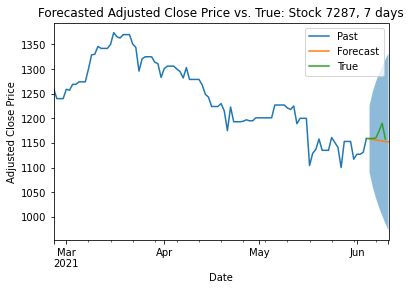

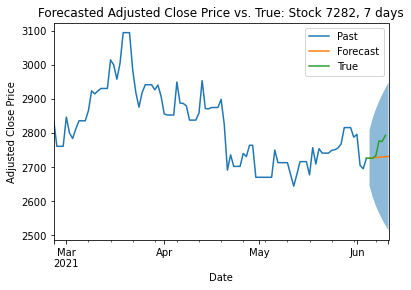

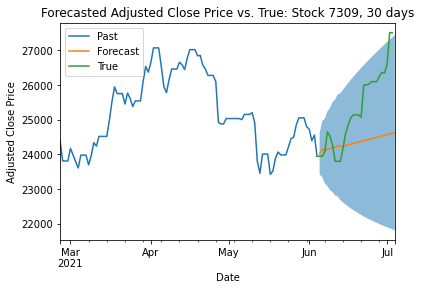

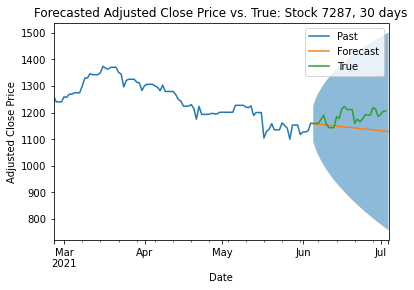

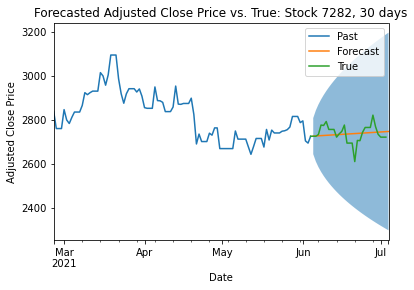

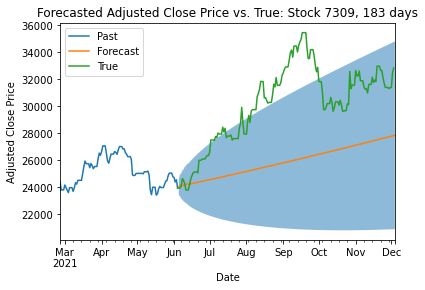

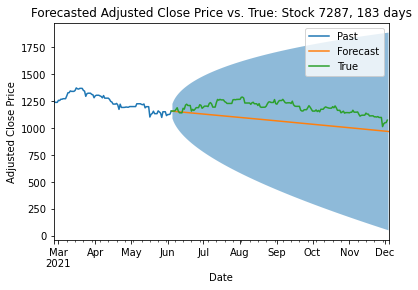

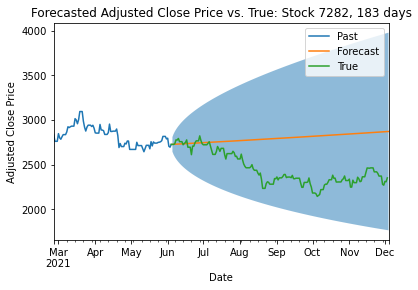

In [38]:
plot_data(df_7309, df_7309_f, results_7309, 7, "Stock 7309")
plot_data(df_7287, df_7287_f, results_7287, 7, "Stock 7287")
plot_data(df_7282, df_7282_f, results_7282, 7, "Stock 7282")
plot_data(df_7309, df_7309_f, results_7309, 30, "Stock 7309")
plot_data(df_7287, df_7287_f, results_7287, 30, "Stock 7287")
plot_data(df_7282, df_7282_f, results_7282, 30, "Stock 7282")
plot_data(df_7309, df_7309_f, results_7309, 183, "Stock 7309")
plot_data(df_7287, df_7287_f, results_7287, 183, "Stock 7287")
plot_data(df_7282, df_7282_f, results_7282, 183, "Stock 7282")

Now we will be computing our evaluation metric, Root Mean Squared Error (RMSE)

In [39]:
#get_rmse function -- computes root mean squared error function based off difference between true value and predicted value
def get_rmse(results, true_values,steps):
    #get the forecasts "steps" steps ahead
    forecast = results.get_forecast(steps=steps)
    #store a dataframe containing predicted values
    stock_change = pd.DataFrame(forecast.predicted_mean)
    #create a column of the true values
    stock_change["Actual_values"]=true_values.iloc[:steps]
    #compute residual
    stock_change["residual"]= stock_change["predicted_mean"] - stock_change["Actual_values"]
    #square the residual
    stock_change["residual_squared"]= stock_change["residual"] ** 2
    #take the mean of the squared residuals
    mse = np.mean(stock_change["residual_squared"])
    #take the square root
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}, RMSE: {rmse}")

Evaluating RMSE for each stock over daily, monthly, half year intervals

In [40]:
#list of stock names
stock = ["7282", "7287", "7309"]
#list of time series models for each stock
result_stocks = [results_7282, results_7287, results_7309]
#storing the true values for each stock
true_values = [df_7282_f, df_7287_f, df_7309_f]

#iterate through each stock
for i in range(3):
    print("Stock ",stock[i])
    #iterate for daily, monthly, half year intervals
    for j in [7, 30, 183]:
        print(f"Interval: {j} days")
        #compute RMSE
        get_rmse(result_stocks[i], true_values[i], j)

Stock  7282
Interval: 7 days
MSE: 2087.561941098668, RMSE: 45.68984505443926
Interval: 30 days
MSE: 1991.6555558672503, RMSE: 44.62796831435698
Interval: 183 days
MSE: 165191.48404018188, RMSE: 406.43755244832124
Stock  7287
Interval: 7 days
MSE: 425.22608795520586, RMSE: 20.621010837376666
Interval: 30 days
MSE: 2516.7487586649477, RMSE: 50.16720800149185
Interval: 183 days
MSE: 18300.358089205598, RMSE: 135.27881611400065
Stock  7309
Interval: 7 days
MSE: 94429.26248344324, RMSE: 307.2934468605591
Interval: 30 days
MSE: 1772658.247851681, RMSE: 1331.4121254711783
Interval: 183 days
MSE: 22530238.116678867, RMSE: 4746.602797441436


## Discussion

Based on our analysis, can we conclude that it is possible to predict the future returns of the stocks using only historical stock performance? Considering our resulting evaluation metrics coupled with the fact that our differenced time-series appear to be white noise processes, we cannot confidently claim that we can use these models to predict the future returns of the stocks traded on the Tokyo Stock Exchange. We would not be comfortable using these models to predict even a few days into the future, much less six months. We conclude that, in order to adequately address our original problem statement/question, we would need to explore far more sophisticated models and techniques. Such techniques include deep learning models, sentiment analysis alongside price history analysis, etc.